Imports: 

In [1]:
import time
import numpy as np
import py_at_broker as pab
from IPython.display import clear_output
import math as math
import pandas as pd
import pylab as pl
import pickle as p
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
b = pab.broker()

%load_ext autoreload
%autoreload 2
from toolbox import kinematic_mapping as km
from toolbox import data_processing as dp
from toolbox import movementtoolbox as mt 


In [2]:
b.register_signal('franka_target_pos', pab.MsgType.target_pos)

True

In [3]:
b.request_signal("franka_state", pab.MsgType.franka_state, True)

True

In [4]:
b.request_signal("franka_lidar", pab.MsgType.franka_lidar)

True

In [5]:
lidar_msg = b.recv_msg("franka_lidar", 7)
print(lidar_msg)

We get franka state and ldiar data on every frame:

In [6]:
def get_polar(theta_old, phi_old, r_old): 
    infeasible = True 
    
    while infeasible:
        theta = np.random.vonmises(theta_old, 2)
        phi = np.random.vonmises(phi_old, 2)
        r = np.random.normal(loc=r_old, scale=0.1)

        pos = r*np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
        pos[0] = abs(pos[0])
        pos[2] = abs(pos[2])
        if np.max(abs(pos)) < 0.8:
            if min(pos[0], pos[2]) > 0.1: 
                infeasible = False
    
    return np.array([theta, phi, r]), pos

In [ ]:
iters = 500
r = np.array([0.2, 0.1, 0.2])
xs = np.zeros((iters, 3))
r, x = get_polar(r[0], r[1], r[2])
x


In [1]:
sleep_time = 0.5
go_time = 0.3

time.sleep(sleep_time)
#x=0.5

target_msg, current_counter= mt.create_message()
b.send_msg('franka_target_pos', target_msg)
time.sleep(sleep_time)


inside_range = True
i = 10
polarity = 1
scaling=1.2
r = np.array([0.2, 0.2, 0.1])

filename = 'robot_random_data_large.p'
cols = ['timestamp_lidar', 'lidar_data', 'timestamp_franka', 'joint_pos', 'joint_vel', 'endeff_pos']
df = pd.DataFrame(columns = cols)
state_msg = b.recv_msg("franka_state", 0)  
ref = state_msg.get_fnumber()


while inside_range : 
    timeth=i/scaling


    #y, z = mt.create_spiral(timeth, 0.005)
    #x, y, z, = generate_random()
    r, pos = get_polar(r[0], r[1], r[2])
    #pos = np.array([x, y, z+0.7])
    
    frame=current_counter+1
    target_msg, current_counter = mt.create_message(counter=frame, pos = pos, go_time=go_time*0.3)

    
    lidar_msg = b.recv_msg("franka_lidar", 5) #-1 waits for the lidar, then...
    state_msg = b.recv_msg("franka_state", 0)        # then we get a signal from the state as fast as possible (tested)
    if state_msg.get_fnumber() == ref: 
        break
    df2 = pd.DataFrame([lidar_msg.get_timestamp(), lidar_msg.get_data(), state_msg.get_timestamp(), 
                        state_msg.get_j_pos(), state_msg.get_j_vel(), state_msg.get_c_pos()],cols)

    df = df.append(df2.T, ignore_index = True)
    ref = state_msg.get_fnumber()
   
    
     
    clear_output(wait = True)
    print(pos)
    #print(polarity)
    b.send_msg('franka_target_pos', target_msg)
    time.sleep(sleep_time)
    i += polarity
    
   # if z > 0.2: 
   #     polarity = -1
   # elif i == 10: 
    #    polarity = 1
        
p.dump(df, open(filename, 'wb'))
print('simulation stopped, wrote data to {}'.format(filename))


NameError: name 'time' is not defined

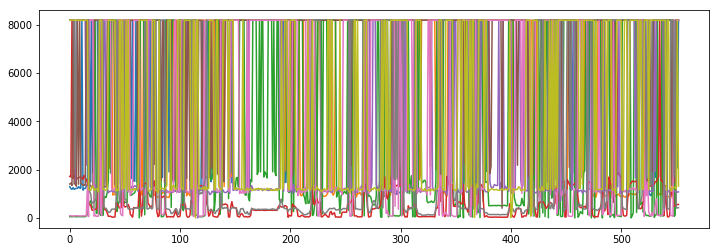

In [9]:
d = p.load(open('new_robot_random_data.p', 'rb'))
lidars = np.array(list(d['lidar_data'].values))
plt.figure(figsize=(12, 4))

plt.plot(lidars)
plt.show()

idx = 8
lidar_data=[]

while True:
    lidar_msg = b.recv_msg("franka_lidar", -1)
    lid = lidar_msg.get_data()
    if (lid[idx]<3000): 
        lidar_data.append(lid[idx])
    plt.plot(lidar_data)
    plt.ylim(0, 1000)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.1)